# LSTM - Long Short Term Memory Networks
Las redes LSTM son un tipo de red neuronal recurrente (RNN) con capacidad para retener y utilizar información a largo plazo. Mediante el uso de unidades de memoria especializadas, las LSTM son capaces de manejar dependencias a largo plazo en secuencias de datos y evitar el problema del desvanecimiento del gradiente, que podría hacer que las RNN simples olvidaran información relevante en secuencias largas.

Las denominadas celdas de memoria, que permiten a la red recordar u olvidar información de manera selectiva a lo largo del tiempo, tienen la siguiente estructura:

+ Puerta de olvido: decide qué información descartar de la celda de memoria.
+ Puerta de entrada: decide qué nueva información se debe agregar.
+ Puerta de salida: decide qué parte de la información actual de la celda se debe pasar a la siguiente capa de la red.

A continuación, se presenta un diagrama de la arquitectura de una red LSTM:

![LSTM.png](img/LSTM.png)

In [1]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

## Carga de los datos y división en training y validation
Inicialmente se cargan los datos y se dividen en dos conjuntos: training y validation.

In [3]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [4]:
# División del dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos: Tokenización, Padding y Sequenciación
Antes de poder emplear los datos en la red neuronal, es crucial preprocesarlos adecuadamente. Dado que las redes neuronales no pueden interpretar texto, este debe ser convertido a números. Para ello, se utiliza la clase Tokenizer de Keras, la cual transforma el texto en secuencias numéricas. Además, para asegurar uniformidad en el procesamiento, se agrega relleno (padding) a las secuencias, garantizando que todas posean la misma longitud.

In [5]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Ajustar el tokenizador en el conjunto de entrenamiento:
    tokenizer.fit_on_texts(X_train)

    # Convertir el texto en secuencias numéricas:
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Obtención de la longitud de la secuencia más larga:
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Obtención del tamaño del vocabulario:
    vocab_size = len(tokenizer.word_index) + 1
    
    # Padding: 
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [6]:
# Definición del Tokenizador:
tokenizer = Tokenizer(oov_token="<OOV>")
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

19


In [7]:
# Conversión del output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

## Modelo de la red neuronal LSTM

In [8]:
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len))

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01))) # Anadimos una regularización L2 para penalizar los pesos grandes y ver si disminuye el overfit

# Output layer
model.add(Dense(23, activation="softmax"))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [10]:
model_path = os.path.join(models_dir, "lstm_l2_model.keras")

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [12]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs = 20,
    batch_size = 64,
    shuffle = True,
    validation_data = (val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/20


1346/1346 [==============================] - ETA: 0s - loss: 2.7235 - accuracy: 0.2842
Epoch 1: val_loss improved from inf to 2.49984, saving model to ./models\lstm_l2_model.keras
1346/1346 [==============================] - 128s 90ms/step - loss: 2.7235 - accuracy: 0.2842 - val_loss: 2.4998 - val_accuracy: 0.3086
Epoch 2/20
1346/1346 [==============================] - ETA: 0s - loss: 2.4220 - accuracy: 0.3159
Epoch 2: val_loss improved from 2.49984 to 2.40429, saving model to ./models\lstm_l2_model.keras
1346/1346 [==============================] - 117s 87ms/step - loss: 2.4220 - accuracy: 0.3159 - val_loss: 2.4043 - val_accuracy: 0.3273
Epoch 3/20
1346/1346 [==============================] - ETA: 0s - loss: 2.3025 - accuracy: 0.3309
Epoch 3: val_loss improved from 2.40429 to 2.38632, saving model to ./models\lstm_l2_model.keras
1346/1346 [==============================] - 116s 86ms/step - loss: 2.3025 - accuracy: 0.3309 - val_loss: 2.3863 - val_accuracy: 0.3239
Epoch 4/2

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 128)           3526016   
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 23)                1495      
                                                        

In [14]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

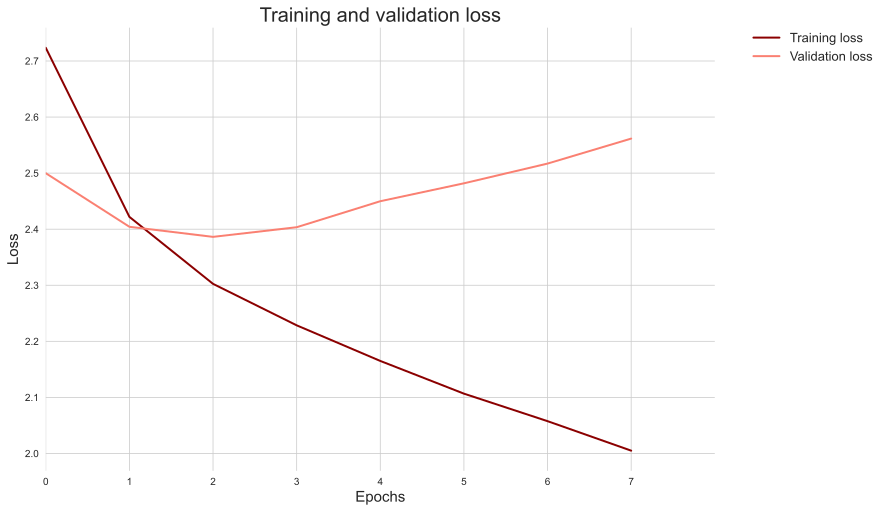

In [16]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 1)

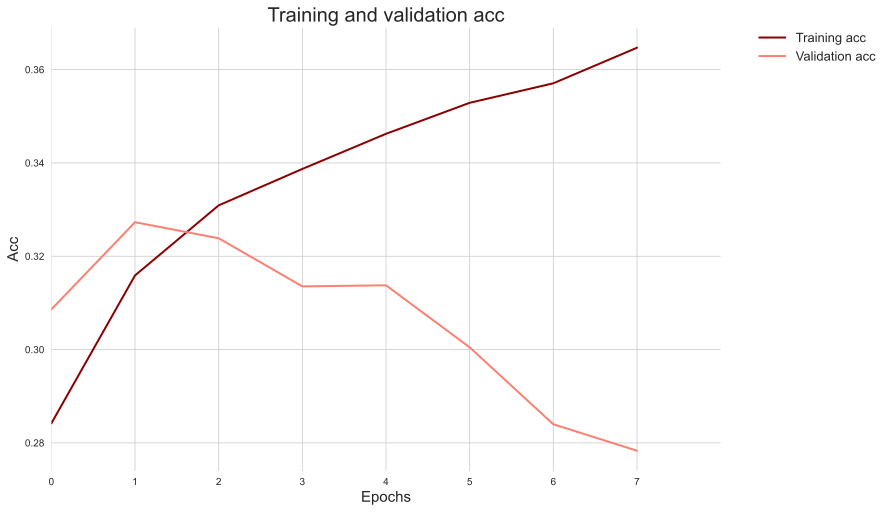

In [17]:
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "acc", 1)

### Predicciones

In [18]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 [==============================] - 5s 7ms/step


In [19]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [20]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 35%,👎 11%,😑 9%
1,NAME like picking choosing life work fact work,😐 29%,🤩 19%,👍 17%
2,How people eat paper plate theyre bbq,😐 34%,🤔 18%,😕 13%
3,Thank voice reason people keep screaming Vatic...,🙏 77%,😐 6%,🤩 3%
4,Gotta love trailing minute,❤️ 49%,😐 14%,🤩 11%
